# Meta-RL-Based Deep Brain Stimulation Study

Neurological disorders, such as Parkinson’s disease, are closely tied to abnormal neuronal synchronization, which manifests as symptoms like tremors and rigidity. Current treatments, such as deep brain stimulation (DBS), often rely on open-loop systems with fixed stimulation patterns. While effective to some extent, these systems lack adaptability, making it challenging to address the dynamic and nonlinear nature of neuronal synchronization.  

This project aims to revolutionize DBS systems by integrating **meta-reinforcement learning (meta-RL)** agents capable of real-time adaptation. The proposed system dynamically adjusts stimulation intensity to suppress pathological neuronal synchronization more efficiently. Unlike traditional DBS methods, which require manual tuning by clinicians and fail to account for individual and temporal variability, a meta-RL approach can learn from diverse neural activity patterns and adapt quickly to new or evolving brain states.  

The use of reinforcement learning (RL) introduces a **data-driven optimization strategy** that does not require explicit knowledge of the underlying neural models. By focusing on meta-RL, this project emphasizes cross-task learning, enabling the agent to generalize its control strategies across a variety of neural synchronization scenarios. This adaptability is critical for tailoring stimulation to the unique and changing requirements of individual patients, improving both therapeutic outcomes and quality of life.  

In essence, this project bridges advanced machine learning techniques with neuroengineering to create a smarter, more personalized, and adaptive neuromodulation framework.

## Senario 1
### 1. Project importing and environment preparation  
These libraries are used for environment simulation, neural network implementation, and visualization.  


In [320]:
!pip install gymnasium numpy torch matplotlib
!pip install gym
!pip install stable-baselines3[extra]

In [321]:
# Import necessary libraries
import numpy as np                
import matplotlib.pyplot as plt   
import torch                      
import torch.nn as nn             
import torch.optim as optim       
from gymnasium import Env         
from gymnasium.spaces import Box  
import gym
from gym import spaces
import random
from collections import deque
import torch.nn.functional as F
import torch.optim as optim

### 2. Define task environment (oscillator_env.py)  
 Define a custom environment that simulates brain oscillatory behavior. The agent will interact with this environment to minimize oscillations and stabilize the system by applying control actions.  


In [322]:
class OscillatorTaskEnv(Env):
    def __init__(self, damping=0.5, frequency=1.0, task_id=0, device=None):
        super(OscillatorTaskEnv, self).__init__()
        self.damping = damping
        self.frequency = frequency
        self.task_id = task_id
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # space
        self.observation_space = Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        self.action_space = Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)

        self.state = 0.0
        self.time = 0.0

    def reset(self, seed=None, **kwargs):
        super().reset(seed=seed)
        self.state = torch.rand(1, device=self.device) * 0.2 - 0.1
        self.time = 0.0
        return self.state.clone()

    def step(self, action):
        if isinstance(action, torch.Tensor):
            voltage = action.item()
        else:
            voltage = action[0]

        state_tensor = torch.tensor(self.state, device=self.device)
        self.state = self.state + (-self.damping * self.state +
                                   self.frequency * torch.sin(torch.tensor(self.time)) +
                                   voltage)
        self.time += 0.1

        # reward
        reward = -abs(self.state.item()) - 0.1 * abs(voltage) - 0.05 * (voltage ** 2)

        terminated = self.time >= 100
        truncated = False
        info = {}

        # state
        return self.state.clone(), reward, terminated, truncated, info

### 3. Define Meta-RL agent (meta_rl_agent.py)  
Define the Meta-RL Agent that uses an Actor-Critic architecture. This agent learns to stabilize the oscillator across multiple tasks.

In [323]:
class Actor(nn.Module):
    def __init__(self, input_dim, action_dim, num_tasks, hidden_dim=128):
        super(Actor, self).__init__()
        self.num_tasks = num_tasks

        self.feature_net = nn.Sequential(
            nn.Linear(input_dim + num_tasks, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.policy_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, action_dim),
            nn.Tanh()
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.orthogonal_(module.weight, gain=np.sqrt(2))
            module.bias.data.zero_()

    def forward(self, state, task_id):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32)

        if state.dim() == 1:
            state = state.unsqueeze(0)  # [D] -> [1, D]
        elif state.dim() == 3:
            state = state.squeeze(1)    # [B, 1, D] -> [B, D]


        if isinstance(task_id, torch.Tensor):
            task_embedding = F.one_hot(task_id, num_classes=self.num_tasks).float()
        else:
            task_embedding = F.one_hot(torch.tensor(task_id), num_classes=self.num_tasks).float()

        if task_embedding.dim() == 1:
            task_embedding = task_embedding.unsqueeze(0)

        if state.device != task_embedding.device:
            task_embedding = task_embedding.to(state.device)

        # task_embedding to match batch size
        if state.size(0) > task_embedding.size(0):
            task_embedding = task_embedding.expand(state.size(0), -1)

        combined_input = torch.cat((state, task_embedding), dim=-1).requires_grad_(True)

        #print('Actor>combined_input grad:', combined_input.requires_grad)
        features = self.feature_net(combined_input)
        #print('Actor>features grad:', features.requires_grad)
        action = self.policy_net(features)

        #print('Actor>state grad:', state.requires_grad)
        #print('Actor>action grad:', action.requires_grad)
        #print('Actor>task_embedding grad:', task_embedding.requires_grad)
        #print('Actor>combined_input grad:', combined_input.requires_grad)

        return action

class Critic(nn.Module):
    def __init__(self, input_dim, action_dim, num_tasks, hidden_dim=128):
        super(Critic, self).__init__()
        self.num_tasks = num_tasks

        self.feature_net = nn.Sequential(
            nn.Linear(input_dim + action_dim + num_tasks, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.value_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.orthogonal_(module.weight, gain=np.sqrt(2))
            module.bias.data.zero_()

    def forward(self, state, action, task_id):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32)
        if not isinstance(action, torch.Tensor):
            action = torch.tensor(action, dtype=torch.float32)

        if state.dim() == 1:
            state = state.unsqueeze(0)
        elif state.dim() == 3:
            state = state.squeeze(1)

        if action.dim() == 1:
            action = action.unsqueeze(0)
        elif action.dim() == 3:
            action = action.squeeze(1)

        if isinstance(task_id, torch.Tensor):
            task_embedding = F.one_hot(task_id, num_classes=self.num_tasks).float()
        else:
            task_embedding = F.one_hot(torch.tensor(task_id), num_classes=self.num_tasks).float()

        if task_embedding.dim() == 1:
            task_embedding = task_embedding.unsqueeze(0)

        if state.device != task_embedding.device:
            task_embedding = task_embedding.to(state.device)

        if state.size(0) > task_embedding.size(0):
            task_embedding = task_embedding.expand(state.size(0), -1)

        combined_input = torch.cat((state, action, task_embedding), dim=-1)
        features = self.feature_net(combined_input)
        value = self.value_net(features)

        return value

class MetaRLAgent:
    def __init__(self, input_dim, action_dim, num_tasks, hidden_dim=128,
                 actor_lr=1e-3, critic_lr=1e-3, gamma=0.99, device=None):
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma

        self.actor = Actor(input_dim, action_dim, num_tasks, hidden_dim).to(self.device)
        self.critic = Critic(input_dim, action_dim, num_tasks, hidden_dim).to(self.device)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)


        self.input_dim = input_dim
        self.action_dim = action_dim
        self.num_tasks = num_tasks

    def select_action(self, state, task_id, deterministic=False):
        #with torch.no_grad():
        state_tensor = torch.as_tensor(state, dtype=torch.float32, device=self.device)
        action = self.actor(state_tensor, task_id)
        if not deterministic:
            # 添加探索噪声
            action += torch.randn_like(action) * 0.1
            action = torch.clamp(action, -1, 1)
        return action

    def compute_value(self, state, action, task_id):
        #with torch.no_grad():
        state_tensor = torch.as_tensor(state, dtype=torch.float32, device=self.device)
        action_tensor = torch.as_tensor(action, dtype=torch.float32, device=self.device)
        value = self.critic(state_tensor, action_tensor, task_id)
        return value

    def update(self, batch, task_id):
        states, actions, rewards, next_states, dones = self._process_batch(batch)

        # 更新 Critic
        with torch.no_grad():
            next_actions = self.actor(next_states, task_id)
            next_values = self.critic(next_states, next_actions, task_id)
            target_values = rewards.unsqueeze(1) + self.gamma * next_values * (1 - dones.unsqueeze(1))
        current_values = self.critic(states, actions, task_id)
        critic_loss = F.mse_loss(current_values, target_values)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=0.5)
        self.critic_optimizer.step()

        # 更新 Actor
        current_actions = self.actor(states, task_id)
        actor_values = self.critic(states, current_actions, task_id)
        actor_loss = -actor_values.mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=0.5)
        self.actor_optimizer.step()

        return {
            'critic_loss': critic_loss.item(),
            'actor_loss': actor_loss.item(),
            'avg_value': current_values.mean().item()
        }

    def _process_batch(self, batch):

        first_item = batch[0]
        if not isinstance(first_item, (tuple, list)) or len(first_item) != 5:
            raise ValueError("Batch items must be tuples/lists of (state, action, reward, next_state, done)")

        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []

        for transition in batch:
            state, action, reward, next_state, done = transition


            if isinstance(state, np.ndarray):
                states.append(state.flatten()) 
            elif isinstance(state, torch.Tensor):
                states.append(state.detach().numpy().flatten())
            else:
                states.append(np.array(state).flatten())


            if isinstance(action, np.ndarray):
                actions.append(action.flatten())
            elif isinstance(action, torch.Tensor):
                actions.append(action.detach().numpy().flatten())
            else:
                actions.append(np.array(action).flatten())

            rewards.append(float(reward))

            if isinstance(next_state, np.ndarray):
                next_states.append(next_state.flatten())
            elif isinstance(next_state, torch.Tensor):
                next_states.append(next_state.detach().numpy().flatten())
            else:
                next_states.append(np.array(next_state).flatten())

            dones.append(float(done))

        states = torch.tensor(np.array(states), dtype=torch.float32, device=self.device)
        actions = torch.tensor(np.array(actions), dtype=torch.float32, device=self.device)
        rewards = torch.tensor(np.array(rewards), dtype=torch.float32, device=self.device)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32, device=self.device)
        dones = torch.tensor(np.array(dones), dtype=torch.float32, device=self.device)

        return states, actions, rewards, next_states, dones

    def save(self, path):
        """保存模型"""
        torch.save({
            'actor_state_dict': self.actor.state_dict(),
            'critic_state_dict': self.critic.state_dict(),
            'actor_optimizer_state_dict': self.actor_optimizer.state_dict(),
            'critic_optimizer_state_dict': self.critic_optimizer.state_dict(),
        }, path)

    def load(self, path):
        """加载模型"""
        checkpoint = torch.load(path)
        self.actor.load_state_dict(checkpoint['actor_state_dict'])
        self.critic.load_state_dict(checkpoint['critic_state_dict'])
        self.actor_optimizer.load_state_dict(checkpoint['actor_optimizer_state_dict'])
        self.critic_optimizer.load_state_dict(checkpoint['critic_optimizer_state_dict'])


Define the memory

In [324]:
class ReplayMemory:
    def __init__(self, capacity, task_specific=True):
        self.capacity = capacity
        self.task_specific = task_specific
        self.memory = {} if task_specific else deque(maxlen=capacity)

    def push(self, task_id, transition):
        if self.task_specific:
            if task_id not in self.memory:
                self.memory[task_id] = deque(maxlen=self.capacity)
            self.memory[task_id].append(transition)
        else:
            self.memory.append((task_id, transition))

    def sample(self, batch_size, task_id=None):
        if self.task_specific:
            if task_id is None:
                raise ValueError("Task ID required for task-specific memory")
            if task_id not in self.memory or len(self.memory[task_id]) < batch_size:
                return None
            batch = random.sample(self.memory[task_id], batch_size)
        else:
            if len(self.memory) < batch_size:
                return None
            sampled = random.sample(self.memory, batch_size)
            task_ids = [item[0] for item in sampled]
            batch = [item[1] for item in sampled]
            return task_ids, batch

        return batch

    def __len__(self):
        if self.task_specific:
            return sum(len(memory) for memory in self.memory.values())

### 4. Train the agent (train_meta_rl.py)

In [335]:
def train_agent(agent, environments,
                num_episodes=1000,
                max_steps=100,
                batch_size=64,
                replay_capacity=10000,
                min_replay_size=1000,
                print_interval=10):

    reward_history = {i: [] for i in range(len(environments))}
    avg_reward_history = {i: [] for i in range(len(environments))}
    critic_loss_history = {i: [] for i in range(len(environments))}
    actor_loss_history = {i: [] for i in range(len(environments))}
    all_iterations_states = []
    all_iterations_actions = []

    replay_memory = ReplayMemory(capacity=replay_capacity, task_specific=True)

    for task_id, env in enumerate(environments):
        print(f"\nTraining on Task {task_id}")
        print(f"Parameters: damping={env.damping}, frequency={env.frequency}")

        print(f"Filling replay memory for task {task_id}...")
        state = env.reset()

        while len(replay_memory.memory.get(task_id, [])) < min_replay_size:
            action = agent.select_action(state, task_id)
            next_state, reward, done, _, _ = env.step(action.detach().numpy())

            replay_memory.push(task_id, (state, action.detach().numpy(),
                                       reward, next_state, done))

            if done:
                state = env.reset()
            else:
                state = next_state

        for iteration in range(num_episodes):
            state = env.reset()
            episode_reward = 0
            episode_steps = 0
            episode_states = 0
            episode_actions = 0

            while episode_steps < max_steps:
                action = agent.select_action(state, task_id)
                next_state, reward, done, _, _ = env.step(action.detach().numpy())

                episode_states += state.item()
                episode_actions += action.item()
                all_iterations_states.append(state.item())
                all_iterations_actions.append(action.item())

                replay_memory.push(task_id, (state, action.detach().numpy(),
                                           reward, next_state, done))

                episode_reward += reward
                episode_steps += 1

                if done:
                    break

                state = next_state

            # Update network
            if batch := replay_memory.sample(batch_size, task_id):
                update_info = agent.update(batch, task_id)
                critic_loss_history[task_id].append(update_info['critic_loss'])
                actor_loss_history[task_id].append(update_info['actor_loss'])

            reward_history[task_id].append(episode_reward)

            if iteration % print_interval == 0:
                avg_reward = np.mean(reward_history[task_id][-print_interval:])
                avg_critic_loss = np.mean(critic_loss_history[task_id][-print_interval:])
                avg_actor_loss = np.mean(actor_loss_history[task_id][-print_interval:])
                print(f"Task {task_id}, Episode {iteration}/{num_episodes}, "
                      f"Avg Reward: {avg_reward:.2f}, "
                      f"Avg Critic Loss: {avg_critic_loss:.4f}, "
                      f"Avg Actor Loss: {avg_actor_loss:.4f}")
                avg_reward_history[task_id].append(avg_reward)


    return reward_history, avg_reward_history, critic_loss_history, actor_loss_history, all_iterations_states, all_iterations_actions

Define function to create multitask enviroments

In [326]:
def create_multitask_envs():
  tasks = [
    {"damping": 0.8, "frequency": 1.0},
    {"damping": 0.9, "frequency": 0.8},
    {"damping": 1.0, "frequency": 0.5},
  ]
  environments = [OscillatorTaskEnv(**task, task_id=i) for i, task in enumerate(tasks)]
  return environments

Define function to run the experiment of training angent

In [334]:
replay_memory

In [336]:
def run_train_agent(environments):
    agent = MetaRLAgent(
        input_dim=1,
        action_dim=1,
        num_tasks=len(environments),
        hidden_dim=128,
        actor_lr=1e-3,
        critic_lr=1e-3
    )


    return train_agent(
        agent=agent,
        environments=environments,
        num_episodes=1000,
        max_steps=100,
        batch_size=64,
        replay_capacity=1000,
        min_replay_size=100,
        print_interval=10
    )

Train the agent

In [329]:
environments = create_multitask_envs()
reward_history, avg_reward_history, critic_loss_history, actor_loss_history, all_iterations_states, all_iterations_actions = run_train_agent(environments)


Training on Task 0
Parameters: damping=0.8, frequency=1.0
Filling replay memory for task 0...
Task 0, Episode 0/1000, Avg Reward: -75.20, Avg Critic Loss: 0.5526, Avg Actor Loss: 0.0887


<ipython-input-322-01179490f23b>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(self.state, device=self.device)
<ipython-input-323-2d3be924076c>:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rewards.append(float(reward))


Task 0, Episode 10/1000, Avg Reward: -70.16, Avg Critic Loss: 0.6431, Avg Actor Loss: 0.6311
Task 0, Episode 20/1000, Avg Reward: -45.94, Avg Critic Loss: 0.3891, Avg Actor Loss: 1.6480
Task 0, Episode 30/1000, Avg Reward: -67.32, Avg Critic Loss: 0.4267, Avg Actor Loss: 3.5456
Task 0, Episode 40/1000, Avg Reward: -76.66, Avg Critic Loss: 0.8330, Avg Actor Loss: 7.3666
Task 0, Episode 50/1000, Avg Reward: -100.23, Avg Critic Loss: 0.8467, Avg Actor Loss: 11.4641
Task 0, Episode 60/1000, Avg Reward: -111.09, Avg Critic Loss: 1.7416, Avg Actor Loss: 19.3901
Task 0, Episode 70/1000, Avg Reward: -76.95, Avg Critic Loss: 1.4064, Avg Actor Loss: 29.9359
Task 0, Episode 80/1000, Avg Reward: -63.45, Avg Critic Loss: 1.3480, Avg Actor Loss: 42.3129
Task 0, Episode 90/1000, Avg Reward: -52.49, Avg Critic Loss: 1.6333, Avg Actor Loss: 54.7402
Task 0, Episode 100/1000, Avg Reward: -48.03, Avg Critic Loss: 1.8040, Avg Actor Loss: 58.0973
Task 0, Episode 110/1000, Avg Reward: -47.88, Avg Critic Loss

Visualize the rewards and loss

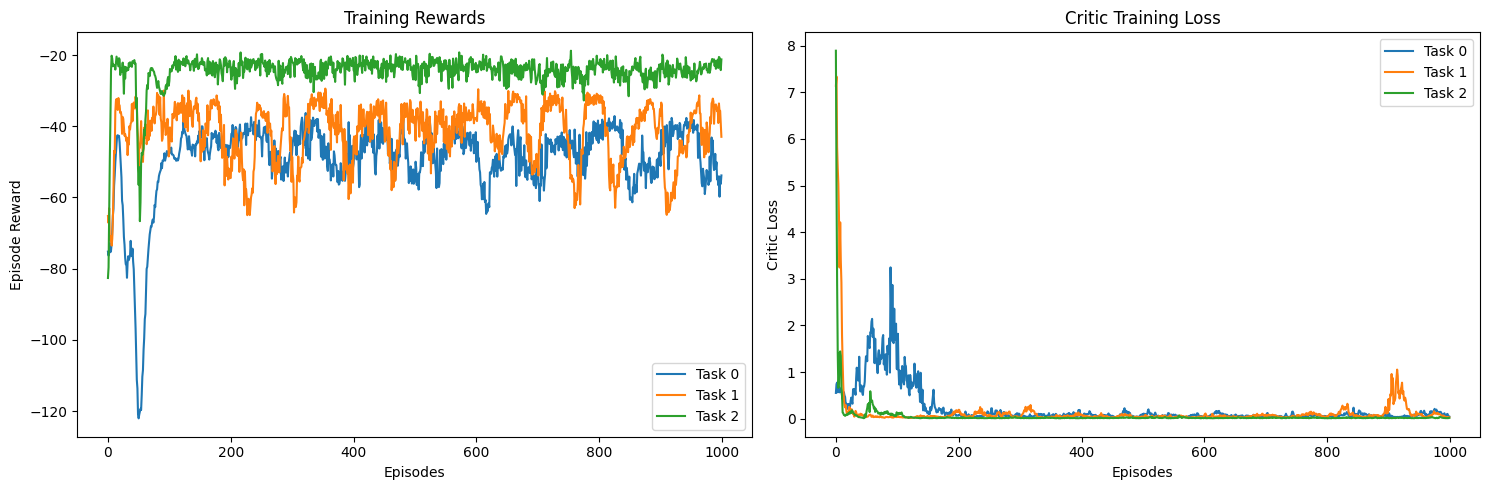

In [330]:
def plot_reward_loss_hist(reward_history, critic_loss_history):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    for task_id in reward_history:
        plt.plot(reward_history[task_id], label=f'Task {task_id}')
    plt.xlabel('Episodes')
    plt.ylabel('Episode Reward')
    plt.title('Training Rewards')
    plt.legend()

    plt.subplot(1, 2, 2)
    for task_id in critic_loss_history:
        plt.plot(critic_loss_history[task_id], label=f'Task {task_id}')
    plt.xlabel('Episodes')
    plt.ylabel('Critic Loss')
    plt.title('Critic Training Loss')
    plt.legend()


    #plt.subplot(1, 3, 3)
    #for task_id in actor_loss_history:
    #    plt.plot(actor_loss_history[task_id], label=f'Task {task_id}')
    #plt.xlabel('Iteration')
    #plt.ylabel('Actor Loss')
    #plt.title('Actor Training Loss')
    #plt.legend()

    plt.tight_layout()
    plt.show()
plot_reward_loss_hist(reward_history, critic_loss_history)

### 4.1 Compare control and unctrol cases

Get data of two cases

In [331]:
def get_control_uncontrol_data(environments, agent, task_id=0, num_episodes=500):
    uncontrol_states = []
    uncontrol_actions = []
    control_states = []
    control_actions = []

    env = environments[task_id]
    state = env.reset()

    action = torch.tensor(0)
    for i in range(num_episodes):
      next_state, _, _, _, _ = env.step(action)
      uncontrol_states.append(state.item())
      uncontrol_actions.append(action.item())
      state = next_state

    state = next_state
    for episode in range(num_episodes):
      action = agent.select_action(state, env.task_id, deterministic=False)
      next_state, reward, done, _, _ = env.step(action.detach().numpy())
      control_states.append(next_state.item())
      control_actions.append(action.item())
      state = next_state

    uncontrol_states = np.array(uncontrol_states)
    uncontrol_actions = np.array(uncontrol_actions)
    control_states = np.array(control_states)
    control_actions = np.array(control_actions)

    return uncontrol_states, uncontrol_actions, control_states, control_actions

In [332]:
test_envs = [OscillatorTaskEnv(damping=0.6, frequency=1.8, task_id=0)]
uncontrol_states, uncontrol_actions, control_states, control_actionss = get_control_uncontrol_data(environments, agent, task_id=0, num_episodes=1000)

<ipython-input-322-01179490f23b>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(self.state, device=self.device)


Visualize the comparison results.

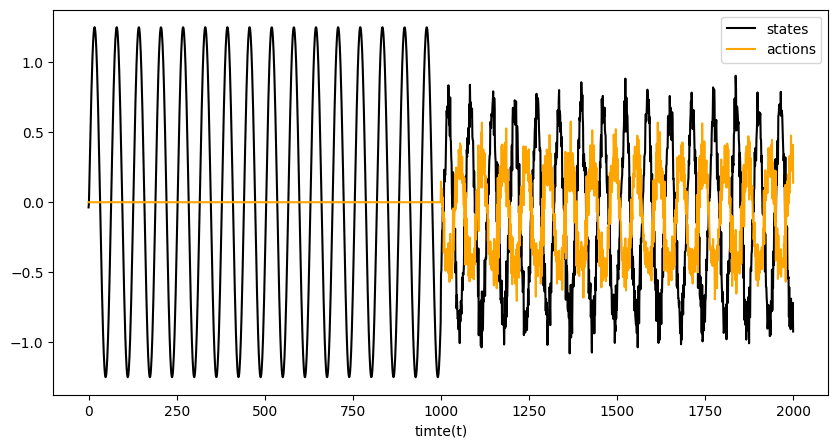

In [333]:
def plot_compare_results(uncontrol_states, uncontrol_actions, control_states, control_actionss):
  all_states = np.hstack((uncontrol_states, control_states))
  all_actions = np.hstack((uncontrol_actions, control_actionss))
  plt.figure(figsize=(10, 5))
  plt.plot(all_states, label='states', color='black')
  plt.plot(all_actions, label='actions', color='orange')
  plt.xlabel('timt(t)')
  plt.legend()
  plt.show()

plot_compare_results(uncontrol_states, uncontrol_actions, control_states, control_actionss)

### 5. Test agent (test_meta_rl.py)

In [ ]:
def evaluate_agent(agent, env, num_episodes=100, max_steps=100):
    all_rewards = []
    all_states = []

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        episode_states = []
        episode_actions = []

        for step in range(max_steps):
            action = agent.select_action(state, env.task_id, deterministic=True)
            next_state, reward, done, _, _ = env.step(action.detach().numpy())

            episode_reward += reward
            episode_states.append(state)
            episode_actions.append(action)

            if done:
                break

            state = next_state

        all_rewards.append(episode_reward)
        all_states.append(episode_states)

    avg_reward = np.mean(all_rewards)

    return avg_reward, episode_states, episode_actions

### 6. Visualization learning speed, final reward and model output (test_meta_rl.py)

In [ ]:
# Visualize results
def plot_results(episode_rewards, final_reward, states, actions):
    """
    Plot the training progress and testing outcomes.
    Args:
    - episode_rewards: List of rewards per training episode.
    - final_reward: Total reward achieved in the test environment.
    - states: Observed states during testing.
    - actions: Actions taken during testing.
    """
    # Plot learning speed
    plt.figure(figsize=(12, 10))

    # Learning speed
    plt.subplot(2, 2, 1)
    plt.plot(episode_rewards, label="Episode Rewards")
    plt.title("Learning Speed")
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.grid(True)

    # Final reward
    plt.subplot(2, 2, 2)
    plt.bar(["Final Reward"], [final_reward])
    plt.title("Final Reward")
    plt.ylabel("Reward")

    # State dynamics
    plt.subplot(2, 2, 3)
    plt.plot(states, label="State Dynamics")
    plt.title("State Dynamics Over Time")
    plt.xlabel("Time Steps")
    plt.ylabel("State")

    # Control actions
    plt.subplot(2, 2, 4)
    plt.plot(actions, label="Control Action", color="red")
    plt.title("Control Actions Over Time")
    plt.xlabel("Time Steps")
    plt.ylabel("Action (Voltage)")
    plt.grid(True)

    plt.tight_layout()
    plt.show()



### 7. Summary and visulization

In [ ]:
# Create environments
tasks = [
    {"damping": 0.8, "frequency": 1.0},
    {"damping": 0.9, "frequency": 0.8},
    {"damping": 1.0, "frequency": 0.5},
]

environments = [OscillatorTaskEnv(**task, task_id=i) for i, task in enumerate(tasks)]

# Initialize agent and optimizer
agent, optimizer = create_agent()

#episode_rewards, all_iterations_actions, all_iterations_states = train_meta_rl_agent(agent, optimizer, environments, num_iterations=10)
episode_rewards, all_iterations_actions, all_iterations_states = train_meta_rl_agent_opt(agent, optimizer, environments, num_iterations=1000)

# Test the agent
test_env = OscillatorTaskEnv(damping=0.6, frequency=1.8)
#final_reward, states, actions = evaluate_final_performance(agent, test_env)

# Plot the results
plot_results(episode_rewards, final_reward, states, actions)

Shape of all_iterations_states: (100, 1)
Shape of all_iterations_actions: (100, 1)
[array([-0.0064463], dtype=float32), array([-0.00643432], dtype=float32), array([-0.006435], dtype=float32), array([-0.00644077], dtype=float32), array([-0.00644171], dtype=float32), array([-0.00644098], dtype=float32), array([-0.00644251], dtype=float32), array([-0.00643238], dtype=float32), array([-0.00643697], dtype=float32), array([-0.00643445], dtype=float32), array([-0.00642874], dtype=float32), array([-0.00643372], dtype=float32), array([-0.00643556], dtype=float32), array([-0.00643748], dtype=float32), array([-0.00643289], dtype=float32), array([-0.00643505], dtype=float32), array([-0.00644565], dtype=float32), array([-0.0064436], dtype=float32), array([-0.00644032], dtype=float32), array([-0.00644017], dtype=float32), array([-0.00644119], dtype=float32), array([-0.00644298], dtype=float32), array([-0.00644695], dtype=float32), array([-0.00642547], dtype=float32), array([-0.00644618], dtype=float

<Figure size 1200x600 with 0 Axes>

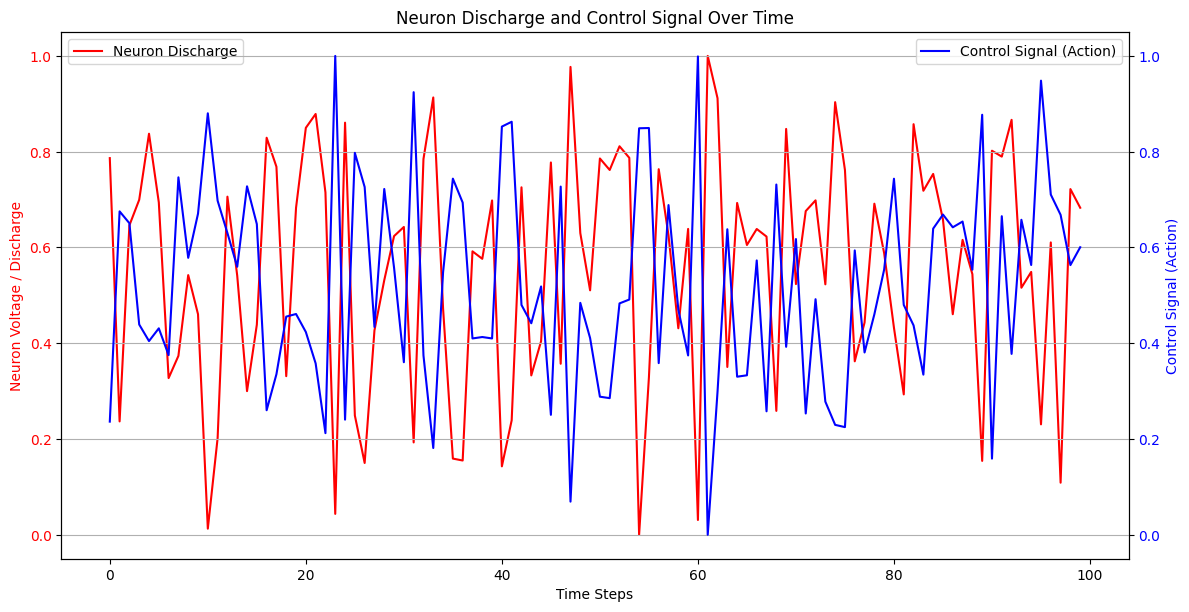

In [ ]:

print("Shape of all_iterations_states:", np.shape(all_iterations_states))
print("Shape of all_iterations_actions:", np.shape(all_iterations_actions))
print(f"{all_iterations_actions}")

def normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

normalized_states = normalize(all_iterations_states)
normalized_actions = normalize(all_iterations_actions)

plt.figure(figsize=(12, 6))

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(normalized_states[:], label="Neuron Discharge", color='r')
ax1.set_xlabel("Time Steps")
ax1.set_ylabel("Neuron Voltage / Discharge", color='r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.plot(normalized_actions[:], label="Control Signal (Action)", color='b')
ax2.set_ylabel("Control Signal (Action)", color='b')
ax2.tick_params(axis='y', labelcolor='b')

fig.tight_layout()
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.title(f"Neuron Discharge and Control Signal Over Time")
plt.grid(True)
plt.show()


In [ ]:

def get_neural_state_before_control(env, steps=10000):
    obs = env.reset()  
    states = []

    for _ in range(steps):
        if isinstance(obs, tuple):
            obs = obs[0]

        obs = np.array(obs, dtype=np.float32)  
        states.append(obs)  
        action = np.random.uniform(-1, 1, size=(1,))
        obs, _, terminated, _, _ = env.step(action)
        if terminated:
            break
    return np.array(states)


def get_neural_state_after_control(agent, env, steps=10000):
    obs = env.reset() 
    hidden_state = (torch.zeros(1, 1, 128), torch.zeros(1, 1, 128))
    states = []

    for _ in range(steps):
       
        if isinstance(obs, tuple):
            obs = obs[0]

        states.append(obs)  
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        action_tensor, hidden_state = agent(obs_tensor, hidden_state)  
        action = action_tensor.detach().numpy()[0]
        obs, _, terminated, _, _ = env.step(action)  
        if terminated:
            break

    return np.array(states)


### 8. PPO Training and Testing

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

tasks = [
    {"damping": 0.3, "frequency": 1.0},
    {"damping": 0.5, "frequency": 1.5},
    {"damping": 0.8, "frequency": 2.0},
]
environments = [OscillatorTaskEnv(**task, task_id=i) for i, task in enumerate(tasks)]
#agent, meta_rl_optimizer = create_agent(input_dim=1, action_dim=1, hidden_dim=128)
env = make_vec_env(lambda: environments[0], n_envs=1) 

model = PPO("MlpPolicy", env, verbose=1)

model.learn(total_timesteps=10000, progress_bar=False )

model.save("ppo_oscillator")

model = PPO.load("ppo_oscillator")

ppo_optimizer = model.policy.optimizer

obs = env.reset()
states = []

for _ in range(10000):
    action, _ = model.predict(obs)
    obs, _, done, _ = env.step(action)
    ppo_states.append(obs[0])  
    ppo_actions.append(action[0])  
    if done:
        break

steps = 10000
before_control = get_neural_state_before_control(environments[0], steps)
meta_rl_states = get_neural_state_after_control(agent, environments[0], steps)
ppo_states = states  

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(before_control[:10000], label="Neuron Discharge with Tremor (Before Control)", color='r')
plt.title("Neuron Discharge with Tremor Pattern (Before Control)")
plt.xlabel("Time (s)")
plt.ylabel("Neuron Voltage / Discharge")
plt.grid(True)
plt.legend()

# Meta-RL
plt.subplot(3, 1, 2)
plt.plot(meta_rl_states[:10000], label="Meta-RL Control", color='g')
plt.title("Neuron Discharge Under Meta-RL Control")
plt.xlabel("Time Steps")
plt.ylabel("Neuron Voltage / Discharge")
plt.legend()
plt.grid(True)

# PPO 
plt.subplot(3, 1, 3)
plt.plot(ppo_states[:10000], label="PPO Control", color='b')
plt.title("Neuron Discharge Under PPO Control")
plt.xlabel("Time Steps")
plt.ylabel("Neuron Voltage / Discharge")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1202 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 814         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014949803 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | 0.00462     |
|    learning_rate        | 0.0003      |
|    loss                 | 451         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0226     |
|    std                  | 0.992       |
|    value_loss           | 1.23e+03    |
-----------------

NameError: name 'ppo_states' is not defined

### 9. Learning rate comparison of meta-rl and ppo  


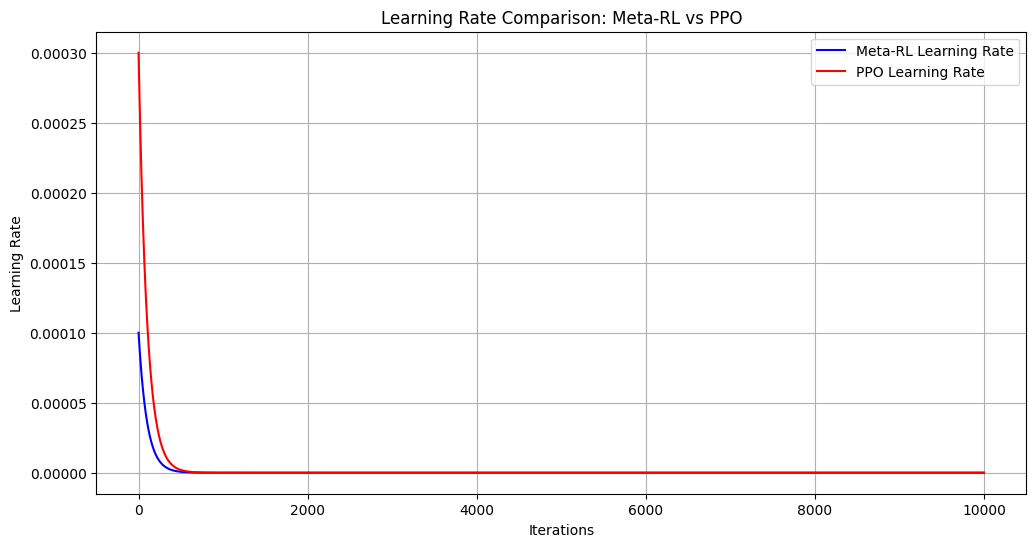

In [ ]:

def plot_learning_rate_comparison(meta_rl_optimizer, ppo_optimizer, num_iterations=10000):
    meta_rl_lr = []
    ppo_lr = []

    for iteration in range(num_iterations):
        for param_group in meta_rl_optimizer.param_groups:
            meta_rl_lr.append(param_group['lr'])

        for param_group in ppo_optimizer.param_groups:
            ppo_lr.append(param_group['lr'])

     
        for param_group in meta_rl_optimizer.param_groups:
            param_group['lr'] *= 0.99 

        for param_group in ppo_optimizer.param_groups:
            param_group['lr'] *= 0.99  

 
    plt.figure(figsize=(12, 6))
    plt.plot(meta_rl_lr, label="Meta-RL Learning Rate", color='b')
    plt.plot(ppo_lr, label="PPO Learning Rate", color='r')
    plt.xlabel("Iterations")
    plt.ylabel("Learning Rate")
    plt.legend()
    plt.title("Learning Rate Comparison: Meta-RL vs PPO")
    plt.grid(True)
    plt.show()

plot_learning_rate_comparison(meta_rl_optimizer, ppo_optimizer, num_iterations=10000)